In [15]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import random

## Image Show Modules (cv and matplotlib)

In [16]:
def cv_show(im,msg):
    cv2.imshow(msg,im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()	

def plt_show(im):
    plt.axis("off")
    plt.imshow(im, cmap="gray")
    plt.show()

## Image Histogram

In [17]:
def histogram(f):
    m, n = f.shape
    # เป็นการสร้างลิสต์ที่มีค่าเริ่มต้นเป็น 0.0 
    # ทำซ้ำ (คูณ) ลิสต์นั้น 256 ครั้ง
    h = [0.0] * 256  
    for i in range(m):
        for j in range(n):
            # เอาค่าพิกเซลในตำแหน่ง (i, j) มาใช้เป็นดัชนีของลิสต์ h แล้วเพิ่มค่าที่ตำแหน่งนั้นขึ้น 1
            h[f[i, j]]+=1 
    return np.array(h, dtype='uint16')

## Intermean Method to repeat calculate mean values between 2 histogram groups

In [18]:
def float2int(x):
    # ถ้าทศนิยมมากกว่าหรือเท่ากับ 0.5 
    if x - math.floor(x) >= 0.5: 
        result = math.ceil(x) # ปัดขึ้น
    else:
        result = math.floor(x) # ปัดลง
    return result

In [19]:
def intermean(hist, t, st, en):
    prob = np.zeros_like(hist, dtype='float16')
    tot = np.sum(hist[st:en])
    prob[st:en] = hist[st:en]/tot
    w0 = np.sum(prob[st:t+1]) + 0.0000001
    w1 = (1 - w0) +  + 0.0000001
    i0 = np.array([i for i in range(st,t+1)])
    i1 = np.array([i for i in range(t+1, en)])
    u0 = np.sum(i0*prob[st:t+1])/w0
    u1 = np.sum(i1*prob[t+1:en])/w1
    if u0 == 0.0:
        thr = u1
    elif u1 == 0.0:
        thr = u0
    else:
        thr = (u0+u1)/2
    return float2int(thr)

## Main Process

ไฟล์นี้เป็นตัวอย่างการใช้งานโมดูลสำหรับแสดงภาพและการคำนวณฮิสโตแกรมของภาพ รวมถึงการใช้วิธี Intermean เพื่อคำนวณค่าเฉลี่ยระหว่างกลุ่มฮิสโตแกรมสองกลุ่ม

ก่อนจะทำ Intermean เราจะต้องคำนวณฮิสโตแกรมของภาพก่อน จากนั้นนำค่าฮิสโตแกรมมาแบ่งเป็นสองกลุ่มหรือก็คือ threshold แล้วคำนวณค่าเฉลี่ยระหว่างสองกลุ่มนั้น

วิธีทำจะมีสองแบบ: แบบทำ threshold ซ้ำ (iterative) และแบบไม่ทำซ้ำ (non-iterative) 
> threshold ซ้ำ จะมี st, en - ช่วงที่พิจารณา (start, end) เพิ่มเข้ามาเพื่อปรับค่า

1. Read Image

In [20]:
img = cv2.imread("./img/gray2.png", cv2.IMREAD_GRAYSCALE)
hist = histogram(img)

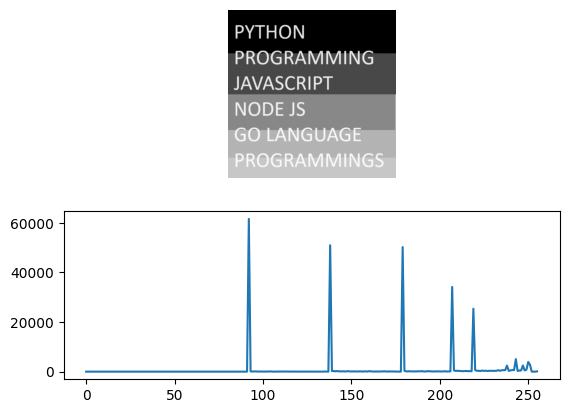

In [21]:
plt.subplot(2, 1, 1)
plt.axis("off")
plt.imshow(img, cmap="gray")

plt.subplot(2, 1, 2)
plt.plot(hist)

plt.show()

In [22]:
# ใช้วิธี Intermean ในการหาค่า threshold โค้ดเก่าที่เพิ่ม st en เข้าไป
def intermean_method(hist,st,en):
    T = []
    t0 = int((st+en)*0.5)
    T.append(t0)
    flag = True
    while(flag):
        t1 = intermean(hist, t0, st, en)
        T.append(t1)
        if abs(t1-t0) <= 1 :
            flag = False
        else:
            t0 = t1
    thr = T[-1]
    print(T, thr)
    return thr

In [23]:
threshs = intermean_method(hist, 0, 256)

[128, 140, 159, 160] 160


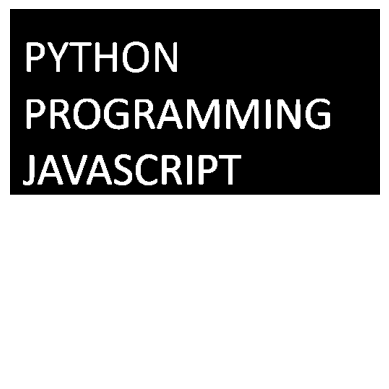

In [24]:

out = np.zeros_like(img, dtype= 'uint8')
out[img > threshs] = 255
plt_show(out)

In [25]:
def plot_histogram(hist, st, en):
    plt.axis("off")
    plt.plot(hist[st:en])
    plt.show()

# ใช้วิธี Intermean แบบวนลูปในการหาค่า threshold
def intermean_loop(hist):
    st, en = 0, 256
    for inx in range(3):
        plot_histogram(hist,st,en)
        threshs = intermean_method(hist, st, en)
        st = threshs+1
    return threshs

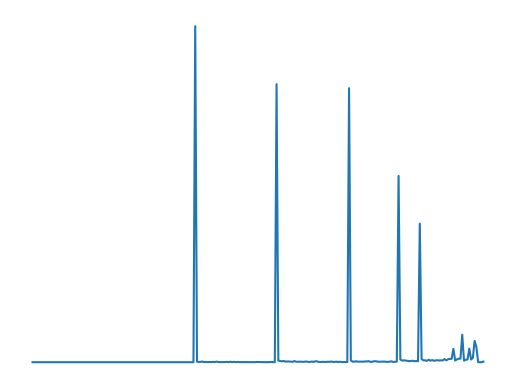

[128, 140, 159, 160] 160


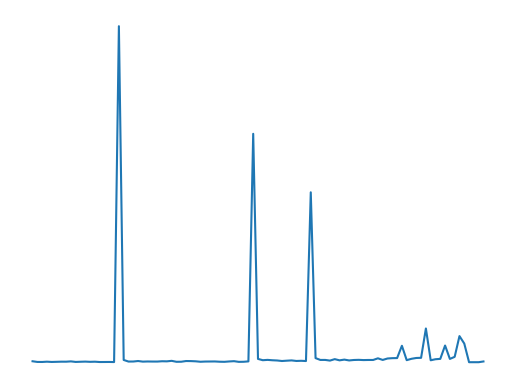

[208, 210, 210] 210


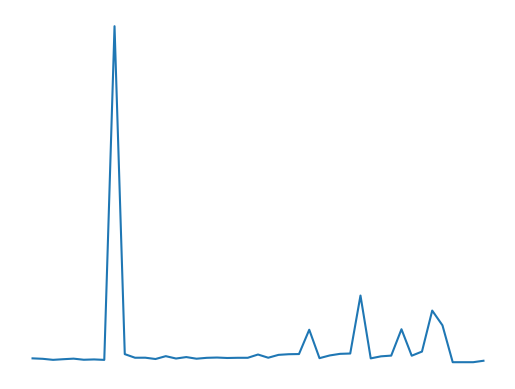

[233, 232] 232
232


In [26]:
threshs = intermean_loop(hist)
print(threshs)

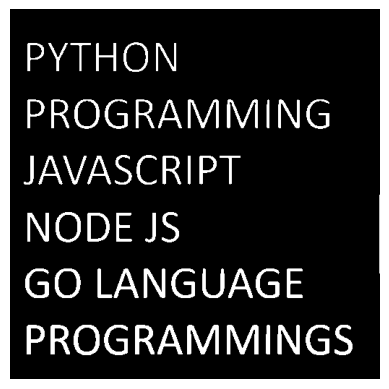

In [27]:
out = np.zeros_like(img, dtype= 'uint8')
out[img > threshs] = 255
plt_show(out)

# อธิบายเพิ่มเติม Intermean Adaptation Method

## เหตุผลของการใช้ Intermean
- **ปัญหา:** Otsu Method ใช้เกณฑ์เดียวสำหรับภาพทั้งหมด → อาจไม่เหมาะสมกับภาพที่มีความสว่างไม่สม่ำเสมอ
- **วิธีแก้:** Intermean Adaptation ใช้หลายเกณฑ์ (multi-level thresholding) → สามารถแยกภาพได้ละเอียดขึ้น

## รายละเอียด Parameters ในฟังก์ชัน

| Parameter | ความหมาย | ตัวอย่าง |
|-----------|----------|---------|
| hist | ฮิสโตแกรมของภาพ | array [100, 200, 150, ...] |
| t | เกณฑ์ปัจจุบัน (threshold) | 128 |
| st | จุดเริ่มต้นของช่วง | 0 (ดำเข้ม) |
| en | จุดสิ้นสุดของช่วง | 256 (ขาวสว่าง) |